# **Predicting Bankruptcy with Machine Learning**  
💡 *Can we use machine learning to identify early warning signs of financial failure and how different traditional methods compare to the ones with machine learning models?*  

# **🔎 Introduction**  
**Objective:**  
This notebook explores how machine learning models can predict company bankruptcy using financial metrics. We'll compare various models and assess their performance against traditional methods like the **Altman Z-score**.  

**Key Challenges:**  
- Highly **imbalanced dataset** (only 6.6% of companies failed).  
- Selecting **relevant financial features**.  
- Comparing **ML models vs. traditional finance models**.  

# **📂 Data Exploration & Preprocessing**  
## 🔹 **Loading the Dataset & Libraries**   

### **Install Dependencies**   

In [4]:
with open('/kaggle/working/requirements.txt', 'w') as f:
    f.write("ipywidgets\n")
    f.write("jupyter\n")
    f.write("shap\n")
    f.write("lightgbm\n")
    f.write("xgboost\n")
    f.write("seaborn\n")
    f.write("imblearn\n")

In [5]:
# Install packages from requirements.txt
!pip install -r /kaggle/working/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 22.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

df = pd.read_csv('/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv')
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## 🔹 **Important Statistics**  

### **Dataset Summary**  
- **Data Types:** 2 categorical, 1 integer, 15 float variables.  
- **Missing Values:** None.  
- **Unique Values:** `company_name` (8,971), `status_label` (2); some numerical features have fewer unique values than records.  
- **Statistics:** Extreme values (e.g., `X8` max **1,073,390**, `X6` min **-98,696**); `X16` is redundant with `X9`.  
- **Records:** 78,682 entries.  
- **Insights:** Outliers require scaling; `X3` is sparse; `year` ranges from **1999 to 2018** for trend analysis.

In [7]:
def summary(df_summary):
    print(f'Data shape: {df_summary.shape}')
    summ = pd.DataFrame(df_summary.dtypes, columns=['Data Type'])
    desc = pd.DataFrame(df_summary.describe(include='all').transpose())
    summ['Minimum'] = desc['min'].values
    summ['Maximum'] = desc['max'].values
    summ['First value'] = df_summary.loc[0].values
    summ['Second value'] = df_summary.loc[1].values
    summ['Third value'] = df_summary.loc[2].values
    summ['Number of Null'] = df_summary.isnull().sum().values
    summ['Number of unique'] = df_summary.nunique().values
    
    return summ

summary(df)

Data shape: (78682, 21)


,Data Type,Minimum,Maximum,First value,Second value,Third value,Number of Null,Number of unique
company_name,object,NaN,NaN,C_1,C_1,C_1,0,8971
status_label,object,NaN,NaN,alive,alive,alive,0,2
year,int64,1999.0,2018.0,1999,2000,2001,0,20
X1,float64,-7.76,169662.0,511.267,485.856,436.656,0,65895
X2,float64,-366.645,374623.0,833.107,713.811,526.477,0,65690
X3,float64,0.0,28430.0,18.373,18.577,22.496,0,36010
X4,float64,-21913.0,81730.0,89.031,64.367,27.207,0,59060
X5,float64,0.0,62567.0,336.018,320.59,286.588,0,38898
X6,float64,-98696.0,104821.0,35.163,18.531,-58.939,0,55550
X7,float64,-0.006,65812.0,128.348,115.187,77.528,0,49577


## 🔹 **Class Distribution (Imbalance Issue)** 
### **Survival Rate Analysis**  
- **Alive Ratio:** 93.4% of instances are "Alive"  
- **Failed Ratio:** 6.6% of instances are "Failed"  
- **Summary:**  
  - The majority of subjects survived, while a small fraction failed, indicating a high survival rate.  
  - The slight shadow effect in the pie chart highlights the small failure proportion.  
  - The skewed distribution suggests most subjects benefit from favorable conditions, while failures may require further investigation.  
- To address class imbalance, SMOTE will be used for models sensitive to undersampling the majority class.

Alive Ratio: 0.9336569990595054
Failed Ratio: 0.06634300094049465


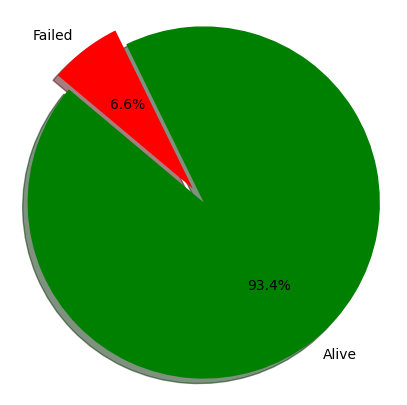

In [8]:
def show_alive_fail_ratio(df_ratio):
    # Given counts and ratios
    alive_count = df_ratio['status_label'].value_counts()['alive']
    failed_count = df_ratio['status_label'].value_counts()['failed']
    total_count = alive_count + failed_count
    alive_ratio = alive_count / total_count
    failed_ratio = failed_count / total_count

    print("Alive Ratio:", alive_ratio)
    print("Failed Ratio:", failed_ratio)

    # Data for the pie chart
    labels = ['Alive', 'Failed']
    sizes = [alive_ratio, failed_ratio]
    colors = ['green', 'red']
    explode = (0.1, 0)  # Explode the first slice

    # Create a pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

    # Save the pie chart as a PNG image
    plt.savefig('pie_chart.png', bbox_inches='tight', dpi=300)
    plt.show()

show_alive_fail_ratio(df)

# **📊 Exploratory Data Analysis (EDA)**  
## 🔹 **Correlation Analysis**  
We use a heatmap to examine relationships between financial features.  
The **correlation matrix** provides insights into the relationships between numerical features, with values ranging from **-1 to 1**:  

- **Strong Positive Correlations**  
  - `X15` and `X18` (**0.78**)  
  - `X3` and `X16` (**0.83**)  
  - These indicate that the variables tend to increase together.  

- **Moderate Correlations**  
  - `X7` and `X14` (**0.75**) suggest a meaningful, but not absolute, dependency.  

- **Weak Correlations**  
  - `X13` and `X14` (**0.01**) imply little to no relationship.  

- **Negative Correlations**  
  - `X1` and `X15` (**-0.67**) show an inverse relationship, where an increase in one corresponds to a decrease in the other.  

These findings highlight potential **multicollinearity issues**, which could impact predictive modeling. **Feature selection** or **dimensionality reduction** may be necessary to mitigate redundancy. Conversely, **weakly correlated features** provide independent information, improving model generalization.  

Further **domain-specific analysis** is recommended to determine whether strong correlations reflect genuine relationships or redundant features.

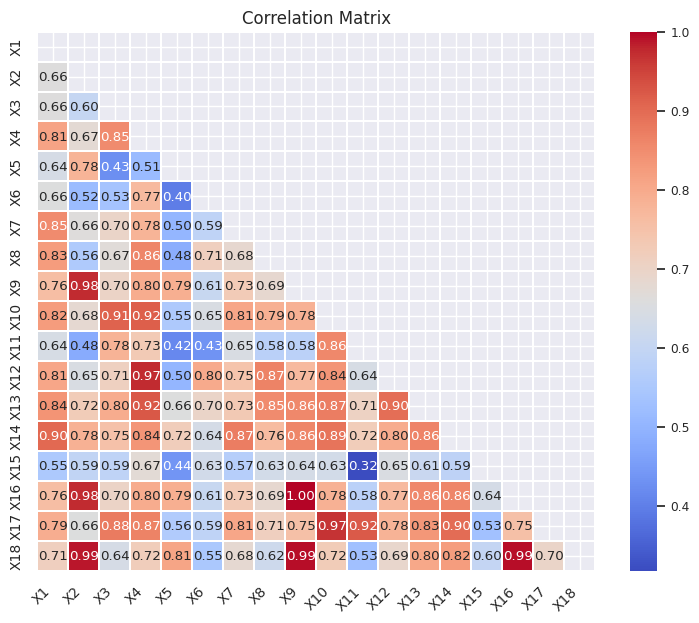

In [9]:
def plot_correlation_matrix(df_matrix):
    # Define variables
    variables = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
    data = df_matrix[variables]

    # Compute correlation matrix
    correlation_matrix = data.corr()
    
    # Mask upper triangle for better readability
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Set plot size and font scale
    plt.figure(figsize=(9, 7))  # Adjusted size for a more compact look
    sns.set(font_scale=0.8)  # Adjust font size relative to plot

    # Create heatmap
    ax = sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f", 
        linewidths=0.3,  # Thinner lines for better aesthetics
        mask=mask, 
        cbar=True  # Keeps color bar for reference
    )

    # Adjust title and layout
    plt.title('Correlation Matrix', fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate labels for readability
    plt.yticks(fontsize=10)

    plt.show()

plot_correlation_matrix(df)

## 🔹 **Box Plot to Detect Outliers**  

The box plot reveals the distribution and outliers in numerical variables:

1. **Outliers:**  
   - Many variables, including **X8, X9, X10, X15, and X16**, show significant outliers beyond the IQR.

2. **Value Scale:**  
   - The y-axis indicates large discrepancies in variable magnitudes, suggesting a need for **feature scaling**.

3. **Class Imbalance and SMOTE:**  
   - Applied **SMOTE** to balance the target variable (company failure vs. survival). While it aids classification, it doesn't resolve outlier issues and may require further preprocessing.

4. **Feature Skewness:**  
   - Most features are right-skewed with medians near the lower range, indicating potential data skewness.

5. **Modeling Implications:**  
   - Outlier handling may involve winsorization or transformations. Understanding extreme values could reveal trends. SMOTE's impact varies by model type.

Next steps include exploring **normalization techniques** and evaluating **SMOTE's effect on model performance**.

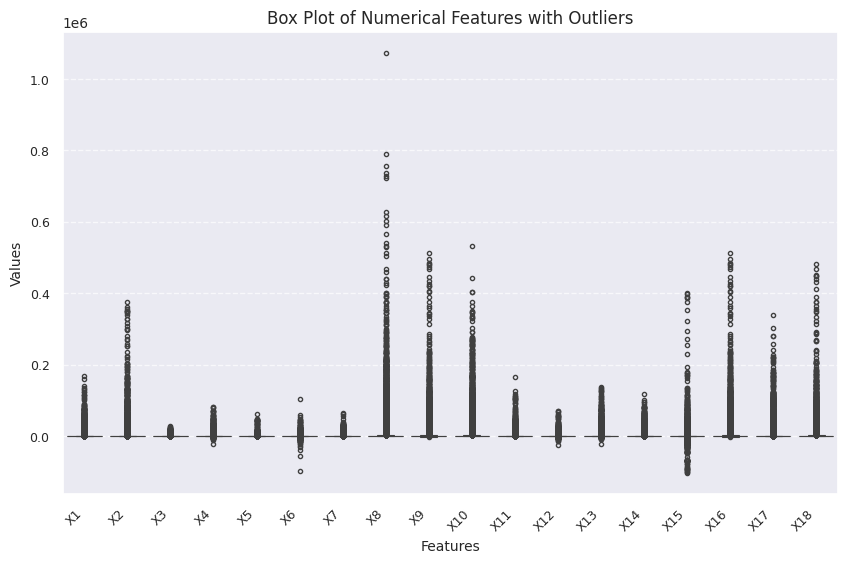

In [10]:
def plot_outliers(df_outliers):
    # Define numerical variables
    variables = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']
    
    # Compute IQR for outliers detection
    Q1 = df_outliers[variables].quantile(0.25)
    Q3 = df_outliers[variables].quantile(0.75)
    IQR = Q3 - Q1

    outliers = (df_outliers[variables] < (Q1 - 1.5 * IQR)) | (df_outliers[variables] > (Q3 + 1.5 * IQR))

    # Set plot size and font scale
    plt.figure(figsize=(10, 6))  # More compact layout
    sns.set(font_scale=0.9)  # Adjust font size to match the new figure size

    # Create box plot
    ax = sns.boxplot(data=df_outliers[variables], linewidth=0.8, fliersize=3)

    # Adjust aesthetics
    plt.xticks(rotation=45, ha="right", fontsize=9)  # Rotate for better readability
    plt.yticks(fontsize=9)
    plt.title("Box Plot of Numerical Features with Outliers", fontsize=12)
    plt.xlabel("Features", fontsize=10)
    plt.ylabel("Values", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add light grid lines for clarity

    plt.show()

plot_outliers(df)

In [11]:
# Pre-processing
df['status_label'] = df['status_label'].map({'alive': 1, 'failed': 0})
X_pre = df.drop(columns=['company_name', 'status_label'])
y_pre = df['status_label']
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,1,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,1,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,1,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,1,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,1,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


# **🛠️ Feature Selection & Data Transformation**
- **Scaling Features:** Standardization helps models perform better.  

- **Handling Imbalanced Data with SMOTE:** 
Feature selection is a crucial step in machine learning that helps improve model performance by identifying the most relevant variables. This process enhances model accuracy, reduces overfitting, and decreases computation time.  Each model uses different feature selection techniques, such as Recursive Feature Elimination (RFE), feature importance ranking, and SHAP (SHapley Additive exPlanations) values.

In [12]:
import shap 
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

def select_features_for_ml(X_train,y_train, df_analysis, model):

    print("Selecting features to train " + model + " model")
    if model == 'SVM':
        # Selected Features Using SVM = ['fyear', 'X1', 'X4', 'X5', 'X6', 'X11', 'X12', 'X13', 'X15', 'X16']
        selected_features = ['year', 'X1', 'X4', 'X5', 'X6', 'X11', 'X12', 'X13', 'X15', 'X16']
        """
        # Step 1: Initialize a Faster SVM Model
        model = SVC(kernel="linear", probability=True)

        # Step 2: Apply RFE with SVM (Select 10 Features)
        rfe = RFE(model, n_features_to_select=10, step=5)  # step=5 speeds up the process
        rfe.fit(X_train, y_train)  # Fit RFE on training data

        # Step 3: Get Selected Feature Names
        selected_features = X_train.columns[rfe.support_].tolist()
        """

        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]
        df_selected.to_csv('svm_selected_features_test_dataset.csv', index=False)
        print("Datasets saved to CSV files.")

    elif model == 'Random Forest':
        #Selected Features Using Random Forest:  ['X8', 'X15', 'X3', 'X1', 'X17', 'X7', 'X13', 'X10', 'X6', 'X14']
        selected_features = ['X8', 'X15', 'X3', 'X1', 'X17', 'X7', 'X13', 'X10', 'X6', 'X14']
        """

        # Random Forest or Decision Tree feature selection
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, y_train)

        feature_importance_rf = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model_rf.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        selected_features = feature_importance_rf['Feature'].head(10).tolist()
        """
        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]
        df_selected.to_csv('rf_selected_features_test_dataset.csv', index=False)
        print("Datasets saved to CSV files.")

    elif model == 'Decision Tree':
        # Selected Features Using Decision Tree:  ['X8', 'X15', 'X3', 'X1', 'X17', 'X7', 'X13', 'X10', 'X6', 'X14']
        selected_features = ['X8', 'X15', 'X3', 'X1', 'X17', 'X7', 'X13', 'X10', 'X6', 'X14']
        """

        # Random Forest or Decision Tree feature selection
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, y_train)

        feature_importance_rf = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model_rf.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        selected_features = feature_importance_rf['Feature'].head(10).tolist()
        """
        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]
        df_selected.to_csv('dt_selected_features_test_dataset.csv', index=False)
        print("Datasets saved to CSV files.")

    elif model == 'XGBoost':
        # Selected Features Using XGBoost:  ['year', 'X8', 'X1', 'X11', 'X10', 'X3', 'X18', 'X15', 'X5', 'X2']
        selected_features = ['year', 'X8', 'X1', 'X11', 'X10', 'X3', 'X18', 'X15', 'X5', 'X2']
        """
        # XGB feature selection
        model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)
        model_xgb.fit(X_train, y_train)

        explainer = shap.Explainer(model_xgb, X_train)
        shap_values = explainer(X_train)

        # Get Mean Absolute SHAP Values for Each Feature
        shap_importance = pd.DataFrame({
            "Feature": X_train.columns,
            "SHAP Importance": abs(shap_values.values).mean(axis=0)
        }).sort_values(by="SHAP Importance", ascending=False)

        # Sort by Importance and Select Top 10 Features
        selected_features = shap_importance['Feature'].head(10).tolist()
        """
        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]
        df_selected.to_csv('xgb_selected_features_test_dataset.csv', index=False)
        print("Datasets saved to CSV files.")

        #shap.summary_plot(shap_values, X_train)
        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]

    elif model == 'Gradient Boosting':
        # Selected Features Using Gradient Boosting:  ['X15', 'X8', 'X5', 'X3', 'year', 'X7', 'X13', 'X2', 'X11', 'X1']
        selected_features = ['X15', 'X8', 'X5', 'X3', 'year', 'X7', 'X13', 'X2', 'X11', 'X1']
        """

        # Gradient Boosting feature selection
        model_gb = LGBMClassifier(n_estimators=100, random_state=42,verbosity=-1)
        model_gb.fit(X_train, y_train)

        feature_importance_gb = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model_gb.feature_importances_
        }).sort_values(by="Importance", ascending=False)

        selected_features = feature_importance_gb['Feature'].head(10).tolist()
        """
        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]
        df_selected.to_csv('gb_selected_features_test_dataset.csv', index=False)
        print("Datasets saved to CSV files.")

    elif model == 'Altman Z-Score':
        # Selected Features Using Altman Z-Score:  ['Z_Score', 'X1', 'X14', 'X10', 'X15', 'X12', 'X8', 'X9', 'year']

        df_analysis['Z_Score'] = df_analysis.apply(
            lambda row: 1.2 * ((row['X1'] - row['X14']) / row['X10']) + 1.4 * (row['X15'] / row['X10'])
                        + 3.3 * (row['X12'] / row['X10']) + 0.6 * (row['X8'] / row['X14']) +
                        1.0 * (row['X9'] / row['X10']), axis=1)
        selected_features = ['Z_Score', 'X1', 'X14', 'X10', 'X15', 'X12', 'X8', 'X9', 'year']
        df_selected = df_analysis[['company_name', 'status_label'] + selected_features]
        df_selected.to_csv('altman_selected_features_test_dataset.csv', index=False)
        print("Datasets saved to CSV files.")

    print("Selected Features Using " + model + ": ", selected_features)

    return selected_features, df_selected

selected_features_rf, df_rf = select_features_for_ml(X_pre, y_pre, df, 'Random Forest')
selected_features_dt, df_dt = select_features_for_ml(X_pre, y_pre, df, 'Decision Tree')
selected_features_gb, df_gb = select_features_for_ml(X_pre, y_pre, df, 'Gradient Boosting')
selected_features_xgb, df_xgb = select_features_for_ml(X_pre, y_pre, df, 'XGBoost')
selected_features_svm, df_svm = select_features_for_ml(X_pre, y_pre, df, 'SVM')
selected_features_alt, df_alt = select_features_for_ml(X_pre, y_pre, df, 'Altman Z-Score')

Selecting features to train Random Forest model
Datasets saved to CSV files.
Selected Features Using Random Forest:  ['X8', 'X15', 'X3', 'X1', 'X17', 'X7', 'X13', 'X10', 'X6', 'X14']
Selecting features to train Decision Tree model
Datasets saved to CSV files.
Selected Features Using Decision Tree:  ['X8', 'X15', 'X3', 'X1', 'X17', 'X7', 'X13', 'X10', 'X6', 'X14']
Selecting features to train Gradient Boosting model
Datasets saved to CSV files.
Selected Features Using Gradient Boosting:  ['X15', 'X8', 'X5', 'X3', 'year', 'X7', 'X13', 'X2', 'X11', 'X1']
Selecting features to train XGBoost model
Datasets saved to CSV files.
Selected Features Using XGBoost:  ['year', 'X8', 'X1', 'X11', 'X10', 'X3', 'X18', 'X15', 'X5', 'X2']
Selecting features to train SVM model
Datasets saved to CSV files.
Selected Features Using SVM:  ['year', 'X1', 'X4', 'X5', 'X6', 'X11', 'X12', 'X13', 'X15', 'X16']
Selecting features to train Altman Z-Score model
Datasets saved to CSV files.
Selected Features Using Altm

## 🔹 **Results: Selected Features for Each Model**  

### **Random Forest & Decision Tree**  
- Feature importance based on Gini impurity; top 10 features selected.

### **Gradient Boosting (LGBMClassifier)**  
- Uses LightGBM’s feature importance scores; top 10 features selected.

### **XGBoost (SHAP Analysis)**  
- Features selected based on SHAP values; highest average SHAP values.

### **Support Vector Machine (SVM)**  
- Recursive Feature Elimination (RFE) selects 10 features.

### **Altman Z-Score**  
- Uses financial ratios; selects Z-score and related metrics.

<div style="overflow-x:auto;">
<table style="width:100%;">
  <tr>
    <th>Model</th>
    <th>Selected Features</th>
  </tr>
  <tr>
    <td><strong>Random Forest</strong></td>
    <td>X8, X15, X3, X1, X17, X7, X13, X10, X6, X14</td>
  </tr>
  <tr>
    <td><strong>Decision Tree</strong></td>
    <td>X8, X15, X3, X1, X17, X7, X13, X10, X6, X14</td>
  </tr>
  <tr>
    <td><strong>Gradient Boosting</strong></td>
    <td>X15, X8, X5, X3, year, X7, X13, X2, X11, X1</td>
  </tr>
  <tr>
    <td><strong>XGBoost</strong></td>
    <td>year, X8, X1, X11, X10, X3, X18, X15, X5, X2</td>
  </tr>
  <tr>
    <td><strong>SVM</strong></td>
    <td>year, X1, X4, X5, X6, X11, X12, X13, X15, X16</td>
  </tr>
  <tr>
    <td><strong>Altman Z-Score</strong></td>
    <td>Z_Score, X1, X14, X10, X15, X12, X8, X9, year</td>
  </tr>
</table>
</div>

### **Key Insights**  
- **Consistency:** Features like **X8, X15, X3, X1** are selected across multiple models.  
- **Model-Specific Focus:** XGBoost prioritizes **X8, X1, X11**, while SVM emphasizes **X4, X5, X6**.  
- **SHAP Impact:** SHAP makes XGBoost's feature selection more interpretable.


# **🤖 Training Machine Learning Models**  
## 🤝 **Supporting Functions**  
The following plots should be shown and saved based on the results of the machine learning model training: 
- **Confusion Matrix**  
- **ROC-AUC Curve**  
- **Precision-Reacall**

In [14]:
def plot_confusion_matrix(ax, cm, method_name):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(method_name + ' Confusion Matrix')

def plot_roc_auc_curve(ax, fpr, tpr, roc_auc, method_name):
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(method_name + ' ROC Curve')
    ax.legend(loc="lower right")
    ax.grid(True)

def plot_precision_recall(ax, recall, precision, method_name):
    ax.plot(recall, precision, color='blue', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(method_name + ' Precision-Recall Curve')
    ax.grid(True)

def plot_all_metrics(cm, fpr, tpr, roc_auc, recall, precision, method_name):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed

    plot_confusion_matrix(axs[0], cm, method_name)
    plot_roc_auc_curve(axs[1], fpr, tpr, roc_auc, method_name)
    plot_precision_recall(axs[2], recall, precision, method_name)

    plt.tight_layout()  # Adjust spacing
    plt.show()

## **📈 Traditional Finance Model: Altman Z-score**  
- A financial analysis tool that computes a Z-score based on financial ratios to assess company viability.

Altman/Logistic Regression Accuracy: 87.62%
Confusion Matrix:
[[  515   553]
 [ 1395 13274]]
Classification Report:
              precision    recall  f1-score   support

           0    0.26963   0.48221   0.34587      1068
           1    0.96001   0.90490   0.93164     14669

    accuracy                        0.87622     15737
   macro avg    0.61482   0.69356   0.63875     15737
weighted avg    0.91315   0.87622   0.89189     15737



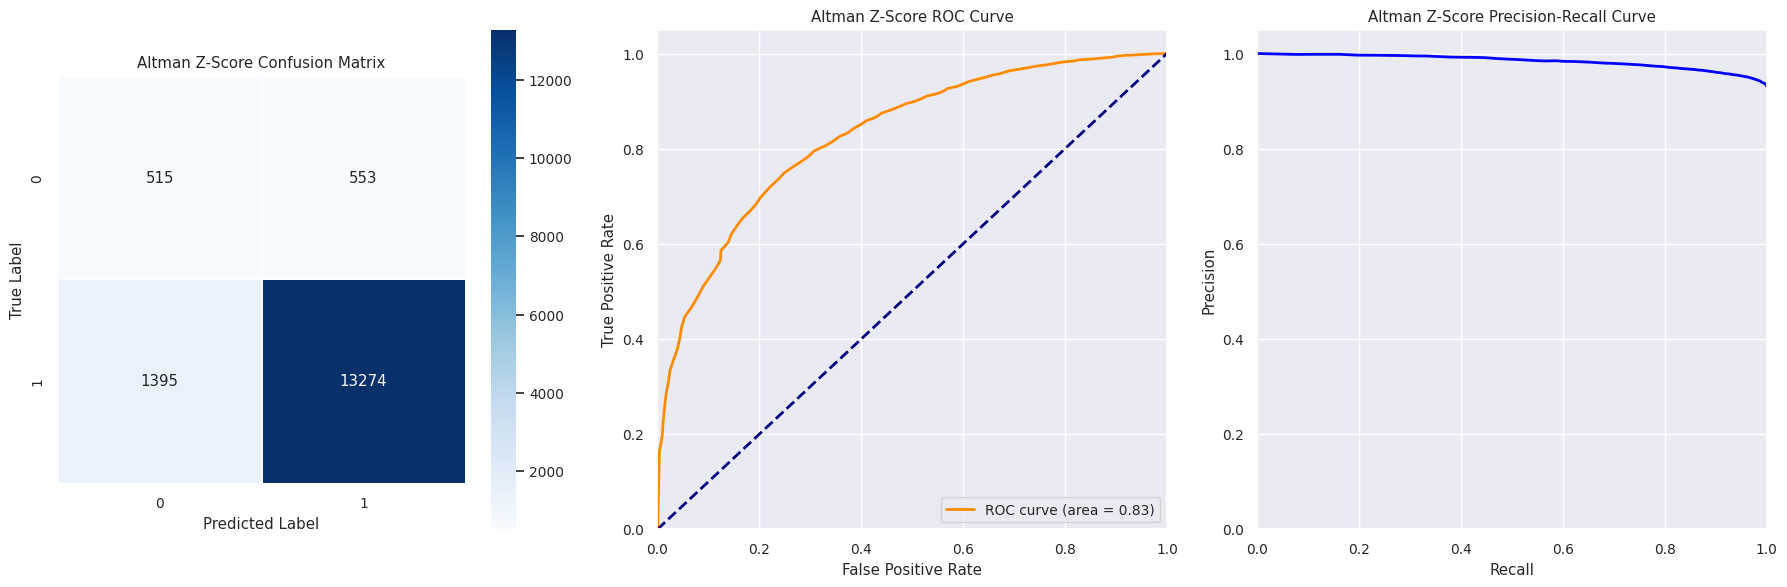

In [15]:
def altman_z_score_classify(df_classify):

    # Define features and target
    X = df_classify.drop(columns=['company_name', 'status_label'], axis=1)
    y = df_classify['status_label']

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train a model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    print("Altman/Logistic Regression Accuracy: {:.2f}%".format(accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred, digits=5)
    print("Classification Report:")
    print(cr)

    # ROC Curve and AUC-ROC
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

    # Calculate F1 Score for Altman
    f1_score_altman = f1_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    average_cv_score = cv_scores.mean()

    # Plot and save confusion matrix, ROC-AUC curve, precision-recall
    plot_all_metrics(cm, fpr, tpr, roc_auc, recall, precision, 'Altman Z-Score')
    
    return roc_auc, accuracy, model, average_cv_score, f1_score_altman

alt_roc_auc, alt_accuracy, alt_model, alt_avg_cv_score, alt_f1_score = altman_z_score_classify(df_alt)

## **📈 Random Forest**  
- A tree-based ensemble method that uses Gini impurity to assess feature importance.

Random Forest Accuracy: 93.51%
Confusion Matrix:
[[   54  1014]
 [    7 14662]]
Classification Report:
              precision    recall  f1-score   support

           0    0.88525   0.05056   0.09566      1068
           1    0.93532   0.99952   0.96635     14669

    accuracy                        0.93512     15737
   macro avg    0.91028   0.52504   0.53101     15737
weighted avg    0.93192   0.93512   0.90726     15737


Cross-Validation Scores:
Fold 1: 93.29%
Fold 2: 93.21%
Fold 3: 93.17%
Fold 4: 93.15%
Fold 5: 93.39%
Average Cross-Validation Score: 93.24%


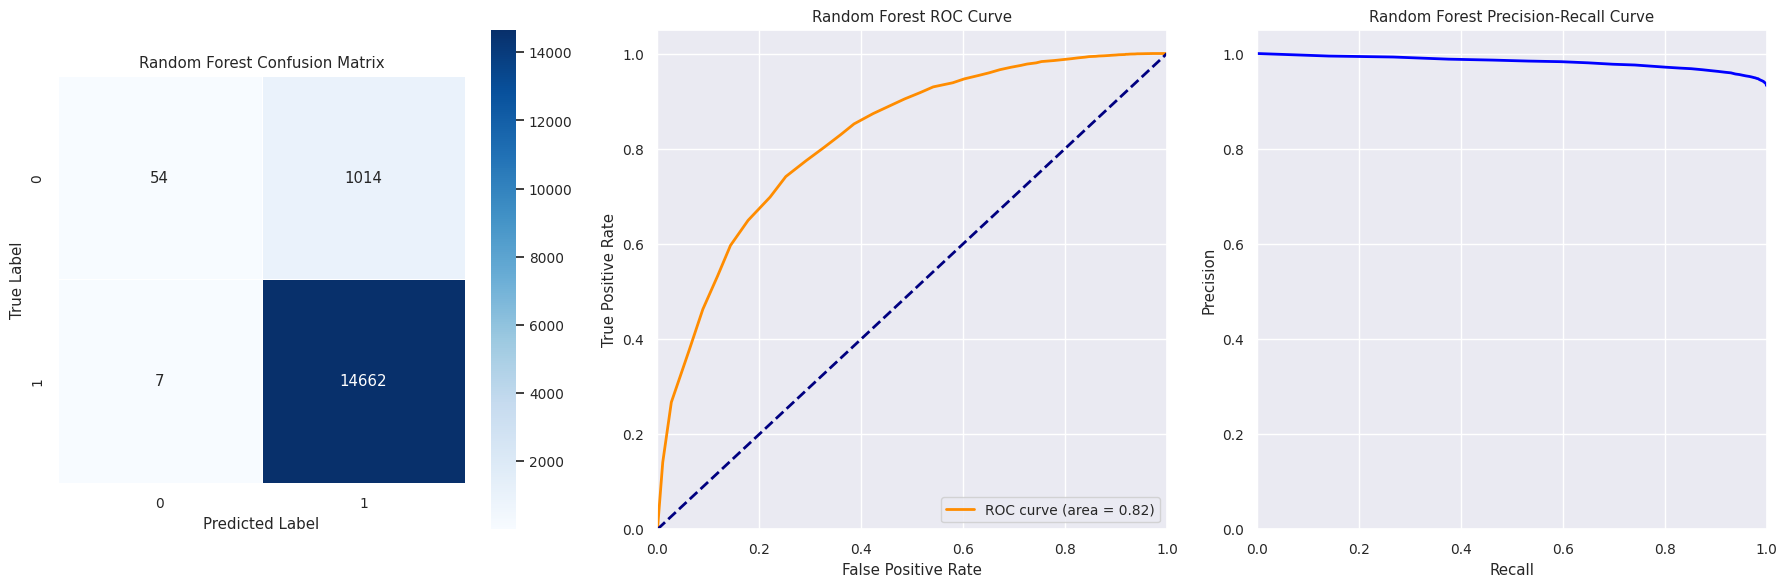

In [16]:
def rf_classify(df_classify):
    # RandomForestClassifier
    X = df_classify.drop(columns=['company_name', 'status_label'], axis=1)
    y = df_classify['status_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Random Forest Accuracy: {:.2f}%".format(accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred, digits=5)
    print("Classification Report:")
    print(cr)

    # ROC Curve and AUC-ROC
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

    #Cross-Validation Scores
    cv_scores = cross_val_score(model, X, y, cv=5)
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores):
        print("Fold {}: {:.2f}%".format(i + 1, score * 100))

    # Average Cross-Validation Score
    average_cv_score = cv_scores.mean()
    print("Average Cross-Validation Score: {:.2f}%".format(average_cv_score * 100))

    # Calculate F1 Score for SVM
    f1_score_rf = f1_score(y_test, y_pred)

    # Plot and save confusion matrix, ROC-AUC curve, precision-recall
    plot_all_metrics(cm, fpr, tpr, roc_auc, recall, precision, 'Random Forest')

    return roc_auc, accuracy, model, average_cv_score, f1_score_rf

rf_roc_auc, rf_accuracy, rf_model, rf_avg_cv_score, rf_f1_score = rf_classify(df_rf)

## **📈 Decision Tree**  
- A straightforward model that visualizes decisions based on feature thresholds, using Gini impurity for importance.

Decision Tree Accuracy: 89.15%
Confusion Matrix:
[[  242   826]
 [  882 13787]]
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.23      0.22      1068
           1       0.94      0.94      0.94     14669

    accuracy                           0.89     15737
   macro avg       0.58      0.58      0.58     15737
weighted avg       0.89      0.89      0.89     15737

Best Decision Tree Accuracy: 93.26%
Confusion Matrix:
[[    8  1060]
 [    1 14668]]
Classification Report:
              precision    recall  f1-score   support

           0    0.88889   0.00749   0.01486      1068
           1    0.93260   0.99993   0.96510     14669

    accuracy                        0.93258     15737
   macro avg    0.91075   0.50371   0.48998     15737
weighted avg    0.92964   0.93258   0.90061     15737



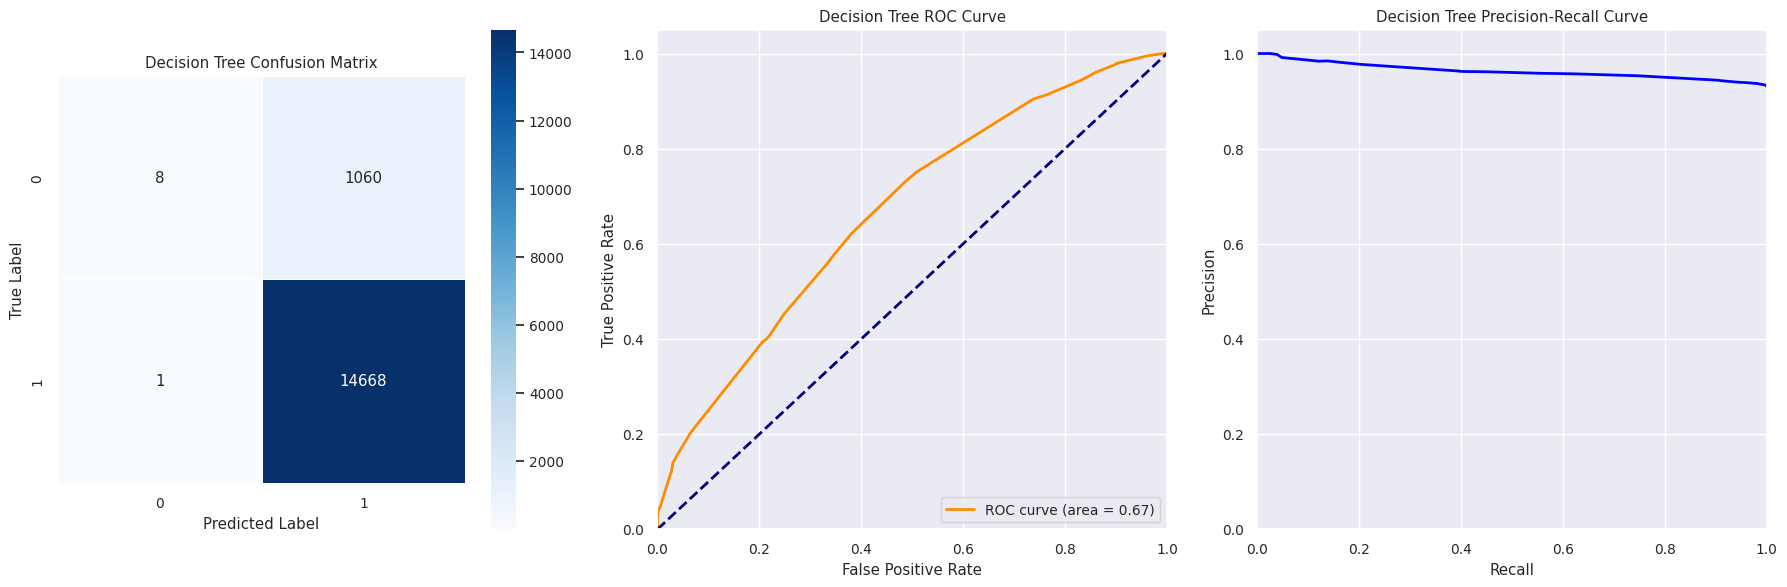

In [17]:
def decision_tree_classify(df_classify):
    # DecisionTreeClassifier
    X = df_classify.drop(columns=['company_name', 'status_label'], axis=1)
    y = df_classify['status_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Decision Tree Accuracy: {:.2f}%".format(accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)

    # Hyperparameters tuning using Grid Search¶
    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    dt_tuned = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(dt_tuned, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_pred = best_model.predict(X_test)
    best_accuracy = accuracy_score(y_test, best_pred)
    print("Best Decision Tree Accuracy: {:.2f}%".format(best_accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_test, best_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, best_pred, digits=5)
    print("Classification Report:")
    print(cr)

    # ROC Curve and AUC-ROC
    y_scores = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

    # Calculate F1 Score for Decision Tree
    f1_score_dt = f1_score(y_test, y_pred)
    cv_scores = cross_val_score(best_model, X, y, cv=5)
    average_cv_score = cv_scores.mean()

    # Plot and save confusion matrix, ROC-AUC curve, precision-recall
    plot_all_metrics(cm, fpr, tpr, roc_auc, recall, precision, 'Decision Tree')

    return roc_auc, best_accuracy, best_model, average_cv_score, f1_score_dt

dt_roc_auc, dt_accuracy, dt_model, dt_avg_cv_score, dt_f1_score = decision_tree_classify(df_dt)

## **📈 Grandient Boosting (LGBMClassifier)**  
- An efficient boosting method that ranks features using built-in importance scores from LightGBM.

Gradient Boosting Accuracy: 93.45%
Confusion Matrix:
[[   23  1021]
 [   10 14683]]
Classification Report:
              precision    recall  f1-score   support

           0    0.69697   0.02203   0.04271      1044
           1    0.93498   0.99932   0.96608     14693

    accuracy                        0.93449     15737
   macro avg    0.81598   0.51068   0.50440     15737
weighted avg    0.91919   0.93449   0.90483     15737



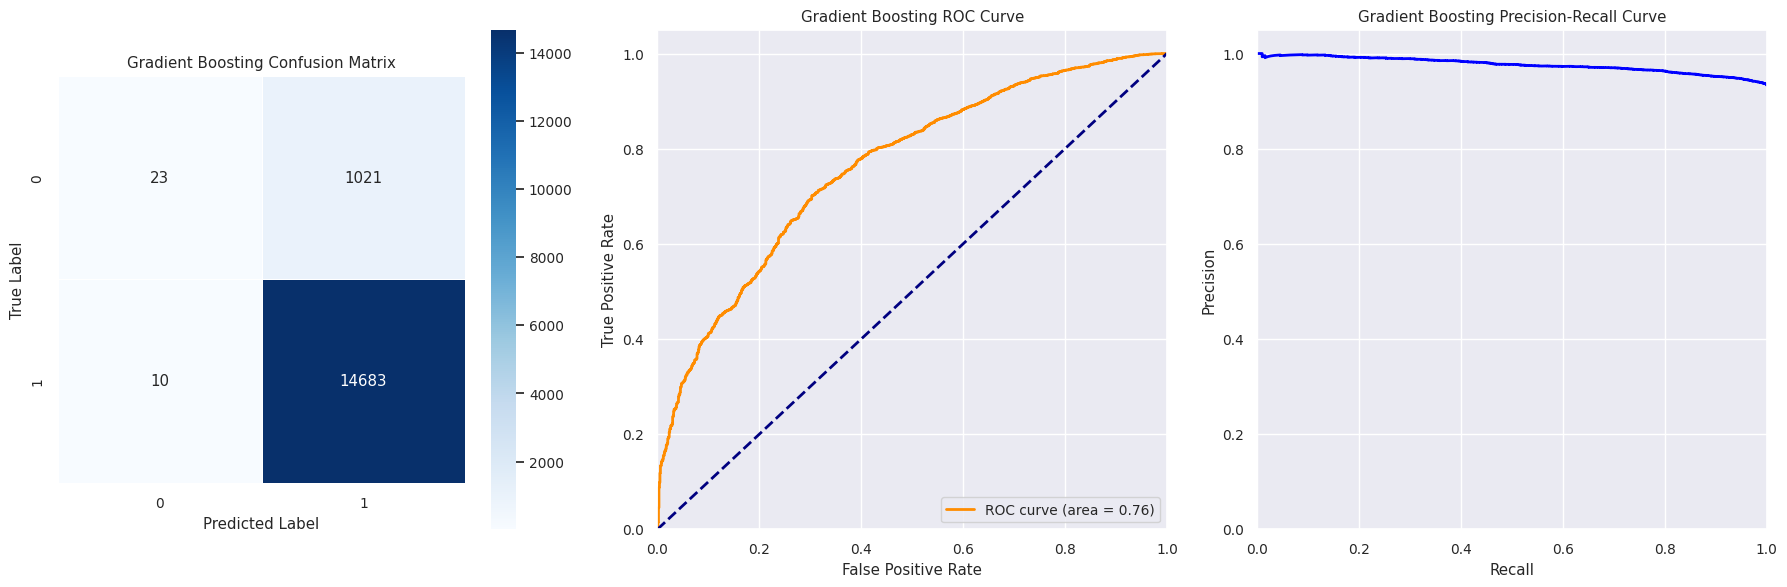

In [18]:
def grad_boosting_classify(df_classify):
    # GradientBoostingClassifier
    X = df_classify.drop(columns=['company_name', 'status_label'], axis=1)
    y = df_classify['status_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Gradient Boosting Accuracy: {:.2f}%".format(accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred, digits=5)
    print("Classification Report:")
    print(cr)

    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)

    # Calculate Cross-Validation Scores for Gradient Boosting
    cv_scores = cross_val_score(model, X, y, cv=5)
    average_cv_score = cv_scores.mean()

    # Calculate F1 Score for Gradient Boosting
    f1_score_gb = f1_score(y_test, y_pred)

    # Plot and save confusion matrix, ROC-AUC curve, precision-recall
    plot_all_metrics(cm, fpr, tpr, roc_auc, recall, precision, 'Gradient Boosting')

    return roc_auc, accuracy, model, average_cv_score, f1_score_gb

gb_roc_auc, gb_accuracy, gb_model, gb_avg_cv_score, gb_f1_score = grad_boosting_classify(df_gb)

## **📈 XGBoost (SHAP Analysis)**  
- A powerful gradient boosting model that utilizes SHAP values for interpretable feature contributions.

XGBoost Accuracy: 93.73%
Confusion Matrix:
[[  126   942]
 [   45 14624]]
Classification Report:
              precision    recall  f1-score   support

           0    0.73684   0.11798   0.20339      1068
           1    0.93948   0.99693   0.96736     14669

    accuracy                        0.93728     15737
   macro avg    0.83816   0.55745   0.58537     15737
weighted avg    0.92573   0.93728   0.91551     15737


Cross-Validation Scores:
Fold 1: 93.23%
Fold 2: 93.13%
Fold 3: 92.73%
Fold 4: 92.60%
Fold 5: 93.23%
Average Cross-Validation Score: 92.98%


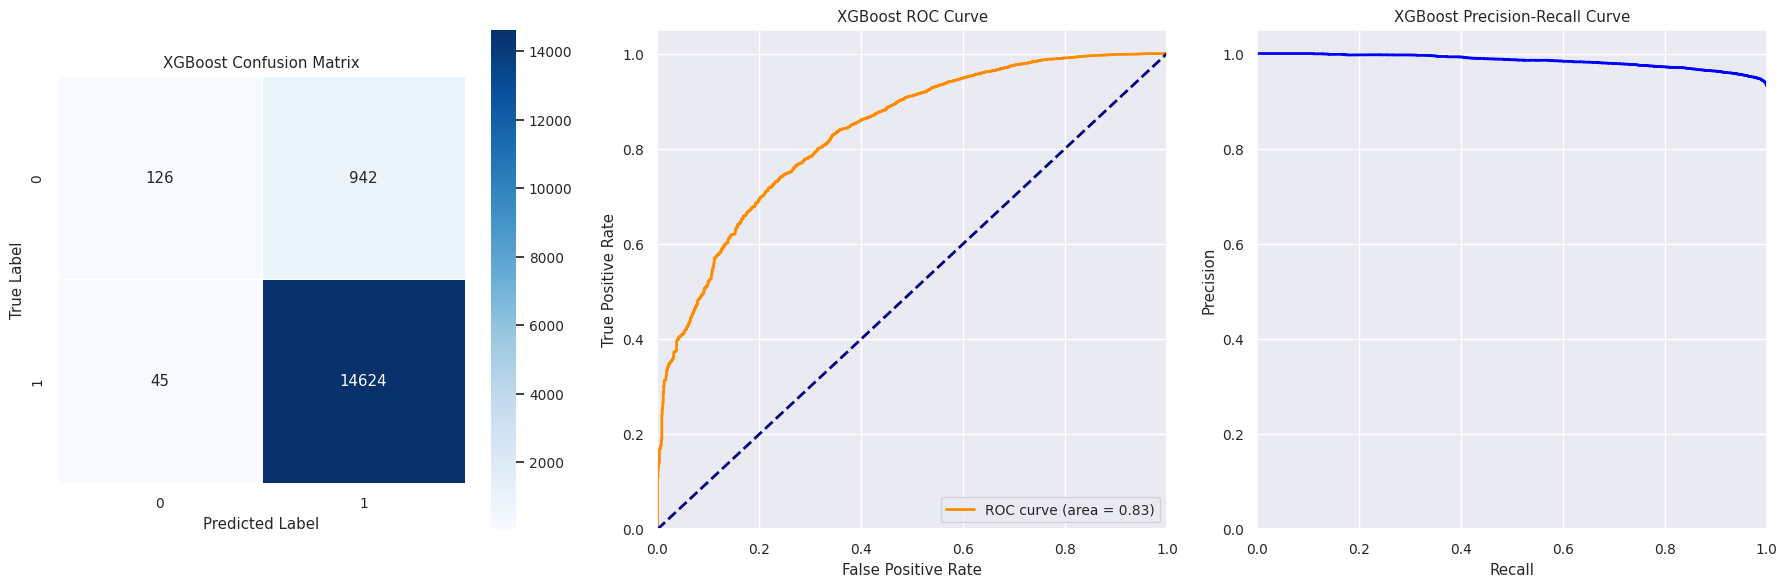

In [19]:
def xgboost_classify(df_classify):

    # Splitting the data
    X = df_classify.drop(columns=['company_name', 'status_label'], axis=1)
    y = df_classify['status_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGB feature selection
    model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("XGBoost Accuracy: {:.2f}%".format(accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred, digits=5)
    print("Classification Report:")
    print(cr)

    # ROC Curve and AUC-ROC
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr_xgb, tpr_xgb)

    # Precision-Recall Curve
    precision_xgb, recall_xgb, thresholds_pr_xgb = precision_recall_curve(y_test, y_scores)

    # Cross-Validation Scores
    cv_scores_xgb = cross_val_score(model, X, y, cv=5)
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_xgb):
        print("Fold {}: {:.2f}%".format(i + 1, score * 100))

    # Average Cross-Validation Score
    average_cv_score = cv_scores_xgb.mean()
    print("Average Cross-Validation Score: {:.2f}%".format(average_cv_score * 100))

    y_scores = model.predict_proba(X_test)[:, 1]
    fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr_xgb, tpr_xgb)

    # Precision-Recall Curve
    precision_xgb, recall_xgb, thresholds_pr_xgb = precision_recall_curve(y_test, y_scores)

    # Calculate F1 Score for Altman
    f1_score_xgb = f1_score(y_test, y_pred)

    # Plot and save confusion matrix, ROC-AUC curve, precision-recall
    plot_all_metrics(cm, fpr_xgb, tpr_xgb, roc_auc, recall_xgb, precision_xgb, 'XGBoost')

    return roc_auc, accuracy, model, average_cv_score, f1_score_xgb

xgb_roc_auc, xgb_accuracy, xgb_model, xgb_avg_cv_score, xgb_f1_score = xgboost_classify(df_xgb)

## **📈 Support Vector Machine (SVM)**  
- A classification algorithm that employs Recursive Feature Elimination to select the most relevant features.

SVM Accuracy: 94.50%
Confusion Matrix:
[[  1  11]
 [  0 188]]
Classification Report:
              precision    recall  f1-score   support

           0    1.00000   0.08333   0.15385        12
           1    0.94472   1.00000   0.97158       188

    accuracy                        0.94500       200
   macro avg    0.97236   0.54167   0.56271       200
weighted avg    0.94804   0.94500   0.92251       200



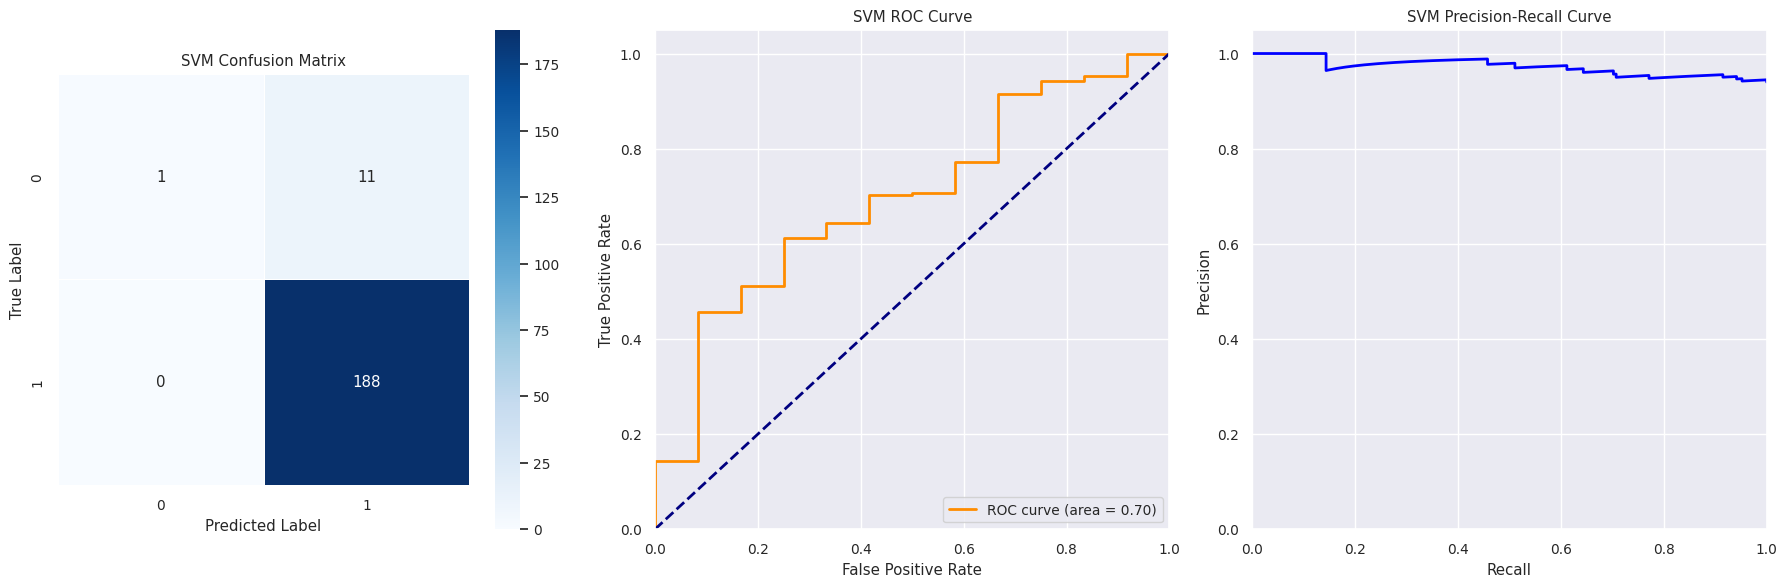

In [20]:
def svm_classify(df_classify):
    df_classify = df_classify.sample(n=min(1000, len(df_classify)), random_state=42)

    X = df_classify.drop(columns=['company_name', 'status_label'], axis=1)
    y = df_classify['status_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Feature selection using SelectKBest
    selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Dimensionality Reduction
    pca = PCA(n_components=10)  # Reduce to 10 principal components
    X_train_pca = pca.fit_transform(X_train_selected)
    X_test_pca = pca.transform(X_test_selected)

    svm_model = LinearSVC()
    svm_model.fit(X_train_pca, y_train)

    y_pred = svm_model.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)
    print("SVM Accuracy: {:.2f}%".format(accuracy * 100))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    cr = classification_report(y_test, y_pred, digits=5)
    print("Classification Report:")
    print(cr)

    y_scores = svm_model.decision_function(X_test_pca)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
    f1_score_svm = f1_score(y_test, y_pred)

    cv_scores = cross_val_score(svm_model, X_train_pca, y_train, cv=3, n_jobs=-1)  # Parallel CV
    average_cv_score = cv_scores.mean()

    # Assuming plot_all_metrics is defined elsewhere
    plot_all_metrics(cm, fpr, tpr, roc_auc, recall, precision, 'SVM')

    return roc_auc, accuracy, svm_model, average_cv_score, f1_score_svm

svm_roc_auc, svm_accuracy, svm_model, svm_avg_cv_score, svm_f1_score = svm_classify(df_svm)

# **📊 6. Results & Comparison**  
- **Model Performance:**  
   - **XGBoost & Random Forest** performed the best.  
   - **SMOTE improved recall for failed companies**.  
   - **Altman Z-score underperformed against ML models**.  

- **Key Takeaways:**  
   - Machine learning can **significantly improve bankruptcy prediction**.  
   - Feature engineering and handling imbalanced data **improves performance**.  

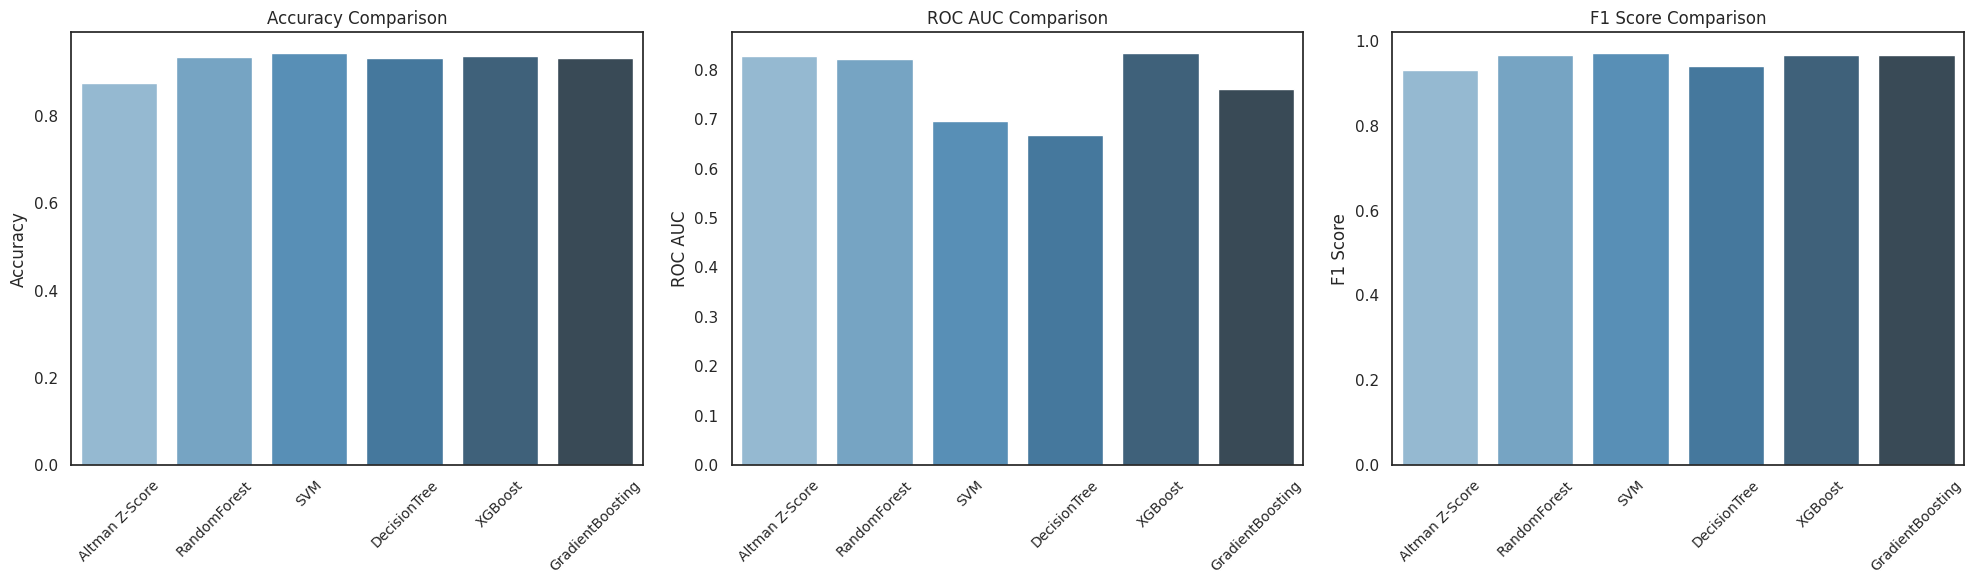

In [21]:
def compare_ml_models(altman_accuracy, rnd_accuracy, svmachine_accuracy, dct_accuracy, xgboodt_accuracy, gboost_accuracy,
                      roc_auc_altman, roc_auc_rnd, roc_auc_svm, roc_auc_dt, roc_auc_xgb, roc_auc_gb,
                      f1_score_altman, f1_score_rf, f1_score_svm, f1_score_dt, f1_score_xgb, f1_score_gb,
                      average_cv_score_altman, rnd_average_cv_score, average_cv_score_svm, average_cv_score_dt,
                      avg_cv_score_xgb, average_cv_score_gb):

    model_metrics = {
        'Model': ['Altman Z-Score', 'RandomForest', 'SVM', 'DecisionTree', 'XGBoost', 'GradientBoosting'],
        'Accuracy': [altman_accuracy, rnd_accuracy, svmachine_accuracy, dct_accuracy, xgboodt_accuracy, gboost_accuracy],
        'ROC AUC': [roc_auc_altman, roc_auc_rnd, roc_auc_svm, roc_auc_dt, roc_auc_xgb, roc_auc_gb],
        'F1 Score': [f1_score_altman, f1_score_rf, f1_score_svm, f1_score_dt, f1_score_xgb, f1_score_gb],
        'Cross-Validation Score': [average_cv_score_altman, rnd_average_cv_score, average_cv_score_svm,
                                   average_cv_score_dt, avg_cv_score_xgb, average_cv_score_gb]
    }

    summary_df = pd.DataFrame(model_metrics)

    sns.set_theme(style="white", rc={"axes.grid": False})

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Create a bar plot for Accuracy
    sns.barplot(x='Model', y='Accuracy', data=summary_df, ax=axes[0], hue='Model', palette="Blues_d", legend=False)
    axes[0].set_title('Accuracy Comparison')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Accuracy')
    axes[0].tick_params(axis='x', rotation=45, labelsize=10)

    # Create a bar plot for ROC AUC
    sns.barplot(x='Model', y='ROC AUC', data=summary_df, ax=axes[1], hue='Model', palette="Blues_d", legend=False)
    axes[1].set_title('ROC AUC Comparison')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('ROC AUC')
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)

    # Create a bar plot for F1 Score
    sns.barplot(x='Model', y='F1 Score', data=summary_df, ax=axes[2], hue='Model', palette="Blues_d", legend=False)
    axes[2].set_title('F1 Score Comparison')
    axes[2].set_xlabel('')
    axes[2].set_ylabel('F1 Score')
    axes[2].tick_params(axis='x', rotation=45, labelsize=10)

    plt.tight_layout()
    plt.savefig('model_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

compare_ml_models(alt_accuracy, rf_accuracy, svm_accuracy, dt_accuracy, xgb_accuracy, gb_accuracy,
                  alt_roc_auc, rf_roc_auc, svm_roc_auc, dt_roc_auc, xgb_roc_auc, gb_roc_auc,
                  alt_f1_score, rf_f1_score, svm_f1_score, dt_f1_score, xgb_f1_score, gb_f1_score,
                  alt_avg_cv_score, rf_avg_cv_score, svm_avg_cv_score, dt_avg_cv_score, xgb_avg_cv_score, gb_avg_cv_score)


## **📌 Conclusion & Next Steps**  
✔ **Machine learning models outperform traditional finance models in predicting bankruptcy.**  
✔ **Feature selection and balancing techniques like SMOTE play a key role in performance.**  
✔ **Further improvements:**  
   - Test on real-world bankruptcy cases.  
   - Fine-tune models with hyperparameter optimization.  
   - Explore deep learning approaches.  

🚀 **If you found this useful, leave an upvote! Let's discuss in the comments!**  